In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from timm.models.swin_transformer import SwinTransformer
from PIL import Image
import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import random

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Callback classes
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss,):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


class ModelCheckpoint:
    def __init__(self, filepath="swin_36class_best.pth", monitor='val_loss', mode='min', save_best_only=True, verbose=False):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = np.Inf if mode == 'min' else -np.Inf

    def __call__(self, metrics, model):
        current = metrics[self.monitor]
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'Model improved from {self.best:.4f} to {current:.4f}. Saving model...')
            self.best = current
            torch.save(model.state_dict(), self.filepath)
        elif not self.save_best_only:
            torch.save(model.state_dict(), self.filepath)

In [3]:
# Dataset class remains the same
class MilkAdulterationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {}  # Mapping for each class label (e.g., 'Fat_1.5_5_water')

        # Iterate through all subdirectories to collect images and labels
        label_counter = 0
        for fat_dir in os.listdir(data_dir):
            fat_path = os.path.join(data_dir, fat_dir)
            if os.path.isdir(fat_path):
                for concentration_dir in os.listdir(fat_path):
                    concentration_path = os.path.join(fat_path, concentration_dir)
                    if os.path.isdir(concentration_path):
                        for adulterant in os.listdir(concentration_path):
                            adulterant_path = os.path.join(concentration_path, adulterant)
                            if os.path.isdir(adulterant_path):
                                for img_file in os.listdir(adulterant_path):
                                    if img_file.endswith(('.jpg', '.jpeg', '.png')):
                                        img_path = os.path.join(adulterant_path, img_file)
                                        self.image_paths.append(img_path)

                                        # Create a unique label for this combination
                                        label = f"{fat_dir}_{concentration_dir}_{adulterant}"
                                        if label not in self.label_mapping:
                                            self.label_mapping[label] = label_counter
                                            label_counter += 1

                                        self.labels.append(self.label_mapping[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a random image if there's an error
            img = Image.new('RGB', (224, 224))

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
data_dir = '/home/nitin/salmaan/RGB'
dataset = MilkAdulterationDataset(data_dir, transform=transform)

In [6]:
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 697
Validation size: 99
Test size: 201


In [7]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(dataset.label_mapping)
print(f"Number of classes: {num_classes}")

Number of classes: 36


Train images and their labels:


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


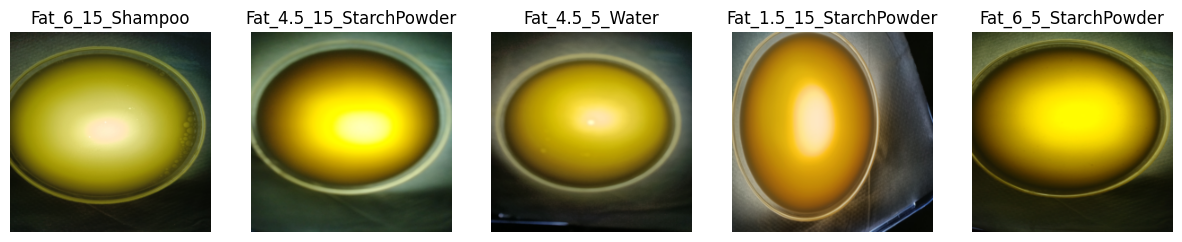

Test images and their labels:


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


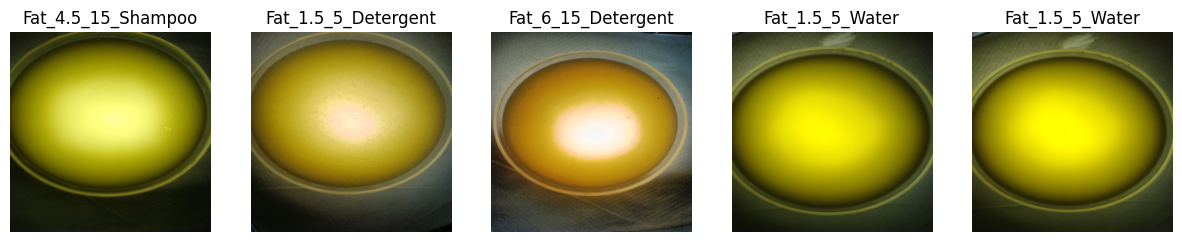

In [8]:
def tensor_to_image(tensor):
    tensor = tensor.cpu().clone()  # Clone the tensor to avoid modification
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = transforms.ToPILImage()(tensor)  # Convert to PIL image
    return tensor

# Function to plot a batch of images from a DataLoader
def plot_images_from_loader(data_loader, num_images=5):
    # Get a batch of images and labels
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    # Get a random sample of images and labels
    indices = random.sample(range(len(images)), num_images)
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    for i, idx in enumerate(indices):
        image = tensor_to_image(images[idx])  # Convert tensor to PIL image
        label = labels[idx].item()
        
        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')
        
        # Get label name from the label mapping
        label_name = list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(label)]
        axes[i].set_title(label_name)

    plt.show()

# Plot images from the train set
print("Train images and their labels:")
plot_images_from_loader(train_loader, num_images=5)

# Plot images from the test set
print("Test images and their labels:")
plot_images_from_loader(test_loader, num_images=5)

In [9]:
model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=num_classes,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    pretrained=True
)

In [10]:
device_list = [0,1,2,3,4,5,6]

In [11]:
print(f"CUDA devices available: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA devices available: 7
Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB
Device 2: NVIDIA A100-SXM4-40GB
Device 3: NVIDIA A100-SXM4-40GB
Device 4: NVIDIA A100-SXM4-40GB
Device 5: NVIDIA A100-SXM4-40GB
Device 6: NVIDIA A100-SXM4-40GB


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(f'cuda:{device_list[0]}')

if torch.cuda.device_count() > 1:
    print(f"Using {len(device_list)} GPUs!")
    model = nn.DataParallel(model, device_ids=device_list)

Using 7 GPUs!


In [13]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Initialize callbacks
early_stopping = EarlyStopping(patience=5, verbose=True)
model_checkpoint = ModelCheckpoint('best_model.pth', monitor='val_loss', mode='min', verbose=True)

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_save_path="swin_36class_best.pth"):
    since = time.time()

    best_acc = 0.0
    best_model_wts = None

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Initialize callbacks
    early_stopping = EarlyStopping(patience=5, verbose=True)
    model_checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_acc', mode='max', save_best_only=True, verbose=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Wrap train_loader with tqdm for progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Train Epoch {epoch}')
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if outputs.dim() > 2:
                    outputs = outputs.view(outputs.size(0), -1)

                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update progress bar
            train_loader_tqdm.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.cpu().numpy())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                if outputs.dim() > 2:
                    outputs = outputs.view(outputs.size(0), -1)

                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_dataset)

        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.cpu().numpy())

        # Print epoch results
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Step the scheduler
        scheduler.step(val_epoch_loss)

        # Callbacks
        metrics = {'val_loss': val_epoch_loss, 'val_acc': val_epoch_acc}

        # EarlyStopping callback check
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

        # ModelCheckpoint callback
        model_checkpoint(metrics, model)

        # Save the model only if the validation accuracy is the best so far
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict().copy()

            # Save only the best model to 'swin_36class_best.pth'
            torch.save(best_model_wts, model_save_path)
            print(f'New best model saved at {model_save_path}!')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [15]:
num_epochs = 30
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_save_path="swin_36class_best.pth"
)

Epoch 0/29
----------


Train Epoch 0:   0%|          | 0/22 [00:00<?, ?it/s]

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]/ho

Train Loss: 3.8337 Acc: 0.0387
Val Loss: 3.5945 Acc: 0.0707
Model improved from -inf to 0.0707. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 1/29
----------


Train Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 3.6571 Acc: 0.0301
Val Loss: 3.6369 Acc: 0.0909
EarlyStopping counter: 1 out of 5
Model improved from 0.0707 to 0.0909. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 2/29
----------


Train Epoch 2:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 3.5408 Acc: 0.0588
Val Loss: 3.3573 Acc: 0.0606

Epoch 3/29
----------


Train Epoch 3:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 3.3061 Acc: 0.0717
Val Loss: 3.3241 Acc: 0.0505

Epoch 4/29
----------


Train Epoch 4:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 3.1193 Acc: 0.1234
Val Loss: 2.8593 Acc: 0.1919
Model improved from 0.0909 to 0.1919. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 5/29
----------


Train Epoch 5:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 2.5769 Acc: 0.2181
Val Loss: 2.2719 Acc: 0.3131
Model improved from 0.1919 to 0.3131. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 6/29
----------


Train Epoch 6:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 2.1258 Acc: 0.3329
Val Loss: 1.7648 Acc: 0.5152
Model improved from 0.3131 to 0.5152. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 7/29
----------


Train Epoch 7:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.7866 Acc: 0.4476
Val Loss: 1.6625 Acc: 0.4747

Epoch 8/29
----------


Train Epoch 8:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.5209 Acc: 0.5280
Val Loss: 1.2681 Acc: 0.5455
Model improved from 0.5152 to 0.5455. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 9/29
----------


Train Epoch 9:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validat

Train Loss: 1.1178 Acc: 0.6973
Val Loss: 0.9222 Acc: 0.7475
Model improved from 0.5455 to 0.7475. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 10/29
----------


Train Epoch 10:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.7949 Acc: 0.7848
Val Loss: 0.6499 Acc: 0.8687
Model improved from 0.7475 to 0.8687. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 11/29
----------


Train Epoch 11:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.5665 Acc: 0.8565
Val Loss: 0.5743 Acc: 0.8384

Epoch 12/29
----------


Train Epoch 12:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.4114 Acc: 0.9125
Val Loss: 0.5936 Acc: 0.7980
EarlyStopping counter: 1 out of 5

Epoch 13/29
----------


Train Epoch 13:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.5002 Acc: 0.8680
Val Loss: 0.4537 Acc: 0.8384

Epoch 14/29
----------


Train Epoch 14:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.2620 Acc: 0.9354
Val Loss: 0.3053 Acc: 0.9293
Model improved from 0.8687 to 0.9293. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 15/29
----------


Train Epoch 15:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.1944 Acc: 0.9684
Val Loss: 0.2722 Acc: 0.9192

Epoch 16/29
----------


Train Epoch 16:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.1446 Acc: 0.9756
Val Loss: 0.2660 Acc: 0.9192

Epoch 17/29
----------


Train Epoch 17:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.1092 Acc: 0.9799
Val Loss: 0.2186 Acc: 0.9394
Model improved from 0.9293 to 0.9394. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 18/29
----------


Train Epoch 18:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.1018 Acc: 0.9857
Val Loss: 0.2143 Acc: 0.9495
Model improved from 0.9394 to 0.9495. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 19/29
----------


Train Epoch 19:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0841 Acc: 0.9871
Val Loss: 0.1971 Acc: 0.9596
Model improved from 0.9495 to 0.9596. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 20/29
----------


Train Epoch 20:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0780 Acc: 0.9842
Val Loss: 0.2272 Acc: 0.9394
EarlyStopping counter: 1 out of 5

Epoch 21/29
----------


Train Epoch 21:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0966 Acc: 0.9842
Val Loss: 0.1906 Acc: 0.9697
Model improved from 0.9596 to 0.9697. Saving model...
New best model saved at swin_36class_best.pth!

Epoch 22/29
----------


Train Epoch 22:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0718 Acc: 0.9871
Val Loss: 0.1907 Acc: 0.9697
EarlyStopping counter: 1 out of 5

Epoch 23/29
----------


Train Epoch 23:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0514 Acc: 0.9943
Val Loss: 0.2475 Acc: 0.9394
EarlyStopping counter: 2 out of 5

Epoch 24/29
----------


Train Epoch 24:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0686 Acc: 0.9828
Val Loss: 0.2179 Acc: 0.9495
EarlyStopping counter: 3 out of 5

Epoch 25/29
----------


Train Epoch 25:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0423 Acc: 0.9928
Val Loss: 0.2009 Acc: 0.9596
EarlyStopping counter: 4 out of 5

Epoch 26/29
----------


Train Epoch 26:   0%|          | 0/22 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Valida

Train Loss: 0.0392 Acc: 0.9971
Val Loss: 0.2003 Acc: 0.9596
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training complete in 137m 22s
Best val Acc: 0.9697


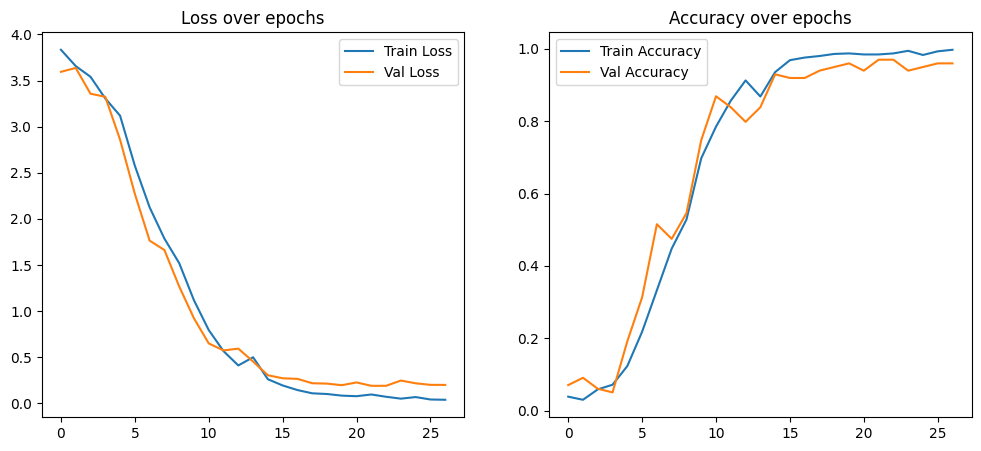

In [16]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

In [17]:
def evaluate_model_with_metrics(model, test_loader, device, criterion, num_classes, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    
    print(f"\nTest Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Get the actual unique classes present in the test set
    unique_classes = np.unique(all_labels)
    present_num_classes = len(unique_classes)
    
    if present_num_classes != num_classes:
        print(f"Warning: Test set contains {present_num_classes} classes out of {num_classes} total classes")
    
    # Classification report
    if class_names is None:
        target_names = [str(i) for i in range(num_classes)]
    else:
        target_names = class_names
    
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=unique_classes,
        target_names=[target_names[i] for i in unique_classes],
        zero_division=0
    ))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=[target_names[i] for i in unique_classes],
        yticklabels=[target_names[i] for i in unique_classes]
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return avg_test_loss, test_accuracy, all_preds, all_labels

In [18]:
def plot_test_metrics(test_loss, test_accuracy, train_loss_history=None, val_loss_history=None, train_acc_history=None, val_acc_history=None):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    if train_loss_history and val_loss_history:
        ax1.plot(train_loss_history, label='Train Loss')
        ax1.plot(val_loss_history, label='Val Loss')
        ax1.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    else:
        ax1.axhline(y=test_loss, color='r', label='Test Loss')
    ax1.set_title('Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    if train_acc_history and val_acc_history:
        ax2.plot(train_acc_history, label='Train Accuracy')
        ax2.plot(val_acc_history, label='Val Accuracy')
        ax2.axhline(y=test_accuracy/100, color='r', linestyle='--', label='Test Accuracy')
    else:
        ax2.axhline(y=test_accuracy/100, color='r', label='Test Accuracy')
    ax2.set_title('Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [19]:
model.eval()

DataParallel(
  (module): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=Tru


Evaluating on test set...


Testing:   0%|          | 0/7 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Testing: 100%|


Test Loss: 0.0231
Test Accuracy: 99.00%

Classification Report:
                         precision    recall  f1-score   support

   Fat_1.5_15_Detergent       1.00      1.00      1.00         2
     Fat_1.5_15_Shampoo       1.00      1.00      1.00         6
       Fat_1.5_15_Water       1.00      1.00      1.00         6
Fat_1.5_15_StarchPowder       1.00      1.00      1.00         5
    Fat_1.5_5_Detergent       1.00      1.00      1.00         3
      Fat_1.5_5_Shampoo       1.00      1.00      1.00         7
        Fat_1.5_5_Water       1.00      1.00      1.00         7
 Fat_1.5_5_StarchPowder       1.00      1.00      1.00         5
   Fat_1.5_10_Detergent       1.00      1.00      1.00         2
     Fat_1.5_10_Shampoo       1.00      1.00      1.00         6
       Fat_1.5_10_Water       1.00      1.00      1.00         5
Fat_1.5_10_StarchPowder       1.00      1.00      1.00         8
   Fat_4.5_15_Detergent       1.00      1.00      1.00         4
     Fat_4.5_15_Shampoo 

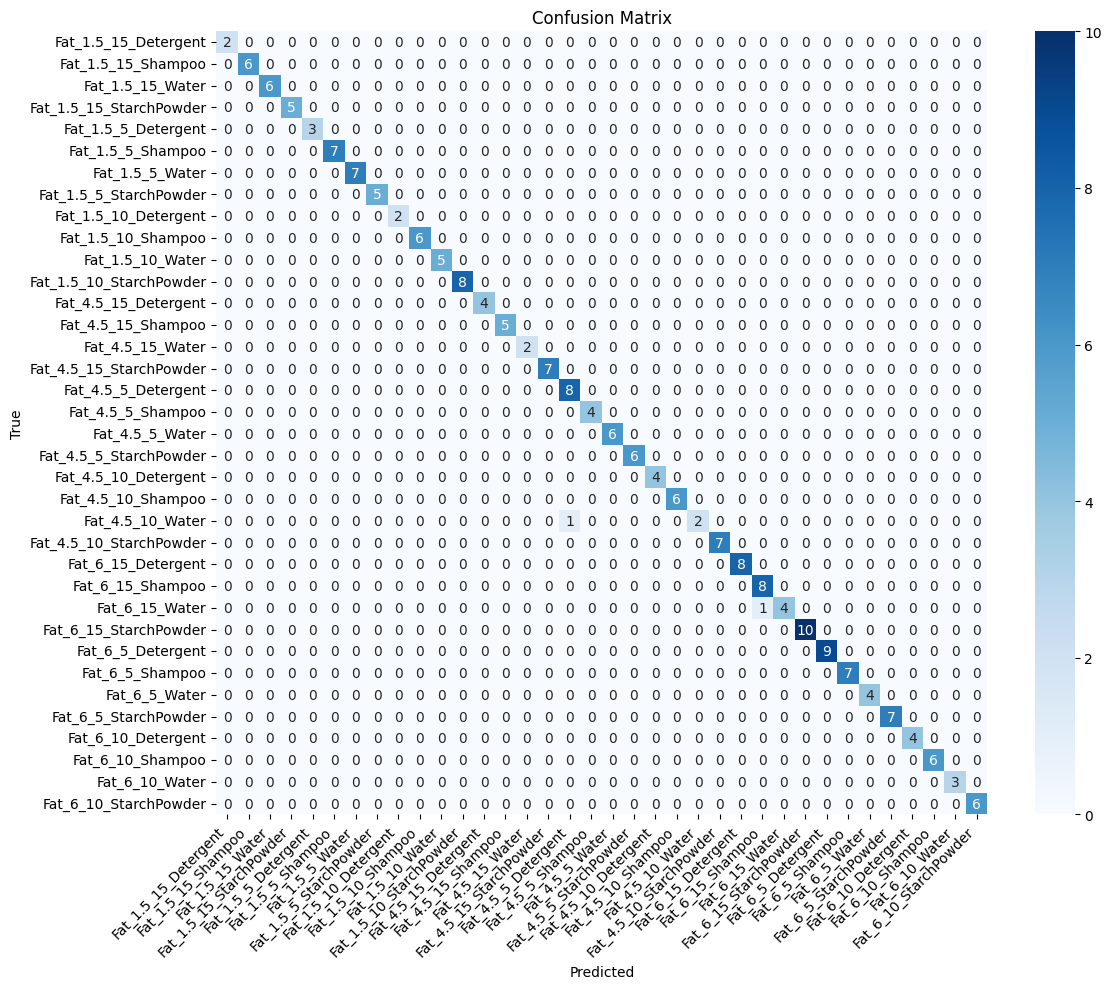

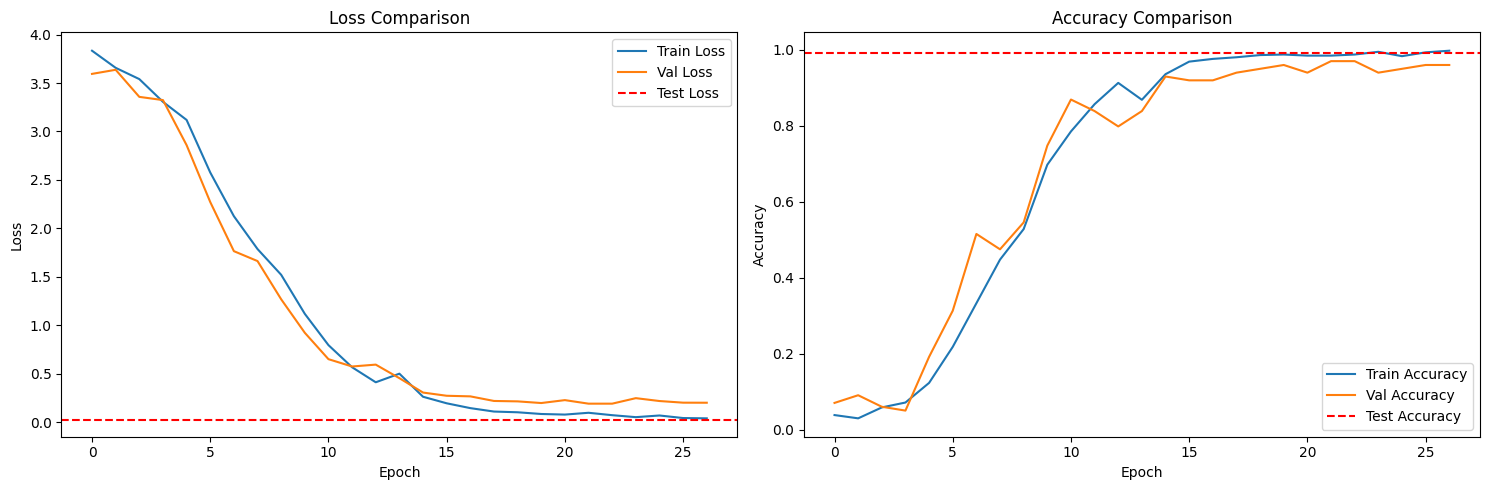

In [21]:
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_preds, test_labels = evaluate_model_with_metrics(
    model, 
    test_loader, 
    device, 
    criterion,  # Your loss function
    num_classes,
    class_names=list(dataset.label_mapping.keys())
)

# Plot test metrics alongside training history
plot_test_metrics(
    test_loss, 
    test_accuracy,
    train_loss_history, 
    val_loss_history,   
    train_acc_history, 
    val_acc_history     
)